In [1]:
from PID import *
import matplotlib.pyplot as plt 
import optuna
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
import numpy as np 
import openpyxl
from tqdm.notebook import tqdm
from openpyxl import Workbook, load_workbook

In [73]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")  # noqa: F405
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 


        
def data_to_X_Y(data, window_size=2):
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        row = [r for r in data[i:i+window_size]]  
        x.append(row)
        label = data[i+window_size][-1]
        y.append(label)
    return np.array(x), np.array(y)
        
def create_model(params: dict):
    """
    Function that automates the creation of a model based
    on the params input
    """
    
    n = params["nhidden"]
    l1 = params["l1"]
    l2 = params["l2"]
    dropout_rate = params["dr"]
    
    model = Sequential()
    model.add(Input((None, 3)))
    model.add(GRU(n,activation="tanh", kernel_regularizer=keras.regularizers.L1L2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(
        loss = "mse",
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
    )

    return model

def get_offline_error(k, model, F=None):
    test = dataset_test[200:500]
    t_sim = t2[200:500]
    
    Y_off = test[:, -1]
    Y_pred = np.empty(t_sim.shape[0])
    
    Y_pred[0] = Y_off[0]
    U_off = test[:, :-1]
    
    
    Y_pred[: k + 1] = Y_off[: k + 1]

    if F is None:
        F = t_sim.shape[0] #if not provided, predict full window

    for n in tqdm(range(k, t_sim.shape[0] - 1)):
        # Use real Y_off values every F steps
        if (n - k + 1) % F == 0:
            Y_pred[n - k + 1:n + 1] = Y_off[n - k + 1:n + 1]
        
        # Prepare the input using either the updated Y_pred or the real Y_off values
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = pre(data_input.reshape(-1, k, 3))
        
        # Predict the next value
        Y_pred[n + 1] = float(model.predict(model_input, verbose=0)[0, 0])

    score = mse(Y_off, Y_pred)
    return score, (Y_off, Y_pred)


def mse(y1, y2):
    return np.mean(np.square(y1 - y2))

def tuna_obj(trial):

    # Decision variables
    n = trial.suggest_int('n_hidden', 1, 50)
    window_size = trial.suggest_int("window_size", 2, 10)
    tuna_params = {
        "nhidden": n,
        "window_size": window_size,
        "l1": trial.suggest_float("l1", 1e-9, 1e-2, log=True),
        "l2": trial.suggest_float("l2", 1e-9, 1e-2, log=True),
        "dr": trial.suggest_float("dr", 0.00, 0.50, step=.01),
    }
    
    tuna_model = create_model(tuna_params)

    x_tuna, y_tuna = data_to_X_Y(dataset_train, window_size = window_size)
    pre.fit(x_tuna)
    xN = pre(x_tuna)
    # fit model
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)
    tuna_model.fit(xN, y_tuna, validation_split=0.30, batch_size=1000, epochs=200, callbacks=[callback],verbose=0)
    final_loss = tuna_model.history.history["loss"][-1]
    final_val_loss = tuna_model.history.history["val_loss"][-1]
    offline_score, _ = get_offline_error(window_size, tuna_model)

    wb = load_workbook(filename)
    ws = wb.active
    ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, offline_score])
    wb.save(filename)
    wb.close()
        
    # Exporting best model
    trial.set_user_attr('tuna_params', tuna_params)
    trial.set_user_attr('model', tuna_model)
    
    return offline_score

In [74]:
# Data Loading
print("LOADING DATA")
dataset_train = np.loadtxt("data/PID_data.csv", delimiter=",")
dataset_test = np.loadtxt("data/PID_data_test.csv", delimiter=",")

pid11 = np.loadtxt("results/PID/PID_reg.csv", delimiter=",")
pid12 = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")

t = dataset_train[:,0]
t2 = dataset_test[:,0]

dt = t[1] - t[0]

dataset_train = dataset_train[:, 1:]
dataset_test = dataset_test[:, 1:]

x_train, _ = data_to_X_Y(dataset_train)

pre = Scaler()
pre.fit(x_train)

print(pre)

filename = "results/GRU/modeling.xlsx"

print("DATA LOADED")

LOADING DATA
min_vals:[7.775      0.01110152 3.3693123 ]
max_vals:[23.325       4.98501725  9.45994836]
DATA LOADED


In [59]:
minimal_params = {
    "nhidden":10,
    "l1":1e-4,
    "l2":1e-4,
    "dr":0.25,
    "window_size":5
}

#test_model = create_model(minimal_params)
#x_train, y_train = data_to_X_Y(dataset_train, window_size=5)
#callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)
#history = test_model.fit(pre(x_train), y_train, validation_split=0.40, batch_size=1000, epochs=200, callbacks=[callback],verbose=1)

In [60]:
import pickle 
try:
    with open("tuna_study.obj", "rb") as file:
        study = pickle.load(file)
        print("STUDY LOADED")
except:
    study = optuna.create_study()
    study.enqueue_trial(minimal_params)
    wb = Workbook()
    ws = wb.active
    ws.title = "GRU"
    ws.append(list(minimal_params.keys()) + ["train loss", "val loss", "offline loss"])
    wb.save(filename)
    wb.close()

study.optimize(tuna_obj, timeout=60*10) #timeout = seconds to run

with open("tuna_study.obj", "wb") as file:
    pickle.dump(study, file)

[I 2024-08-21 17:11:17,965] A new study created in memory with name: no-name-d02e745b-da9a-4260-8f56-3f327143eab7


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-21 17:12:39,152] Trial 0 finished with value: 0.21896361997344976 and parameters: {'n_hidden': 4, 'window_size': 5, 'l1': 0.0001, 'l2': 0.0001, 'dr': 0.25}. Best is trial 0 with value: 0.21896361997344976.


  0%|          | 0/289 [00:00<?, ?it/s]

[I 2024-08-21 17:14:44,372] Trial 1 finished with value: 0.17725300345340445 and parameters: {'n_hidden': 7, 'window_size': 10, 'l1': 0.00035544012343845276, 'l2': 2.554206893100452e-08, 'dr': 0.4}. Best is trial 1 with value: 0.17725300345340445.


  0%|          | 0/289 [00:00<?, ?it/s]

[I 2024-08-21 17:19:27,358] Trial 2 finished with value: 0.028186561681807075 and parameters: {'n_hidden': 31, 'window_size': 10, 'l1': 6.287700225938201e-05, 'l2': 7.925982284997983e-09, 'dr': 0.28}. Best is trial 2 with value: 0.028186561681807075.


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-21 17:21:58,570] Trial 3 finished with value: 0.34411772696744825 and parameters: {'n_hidden': 25, 'window_size': 5, 'l1': 0.002429439609557993, 'l2': 2.6289618042109144e-05, 'dr': 0.35000000000000003}. Best is trial 2 with value: 0.028186561681807075.


In [61]:
# Obtaining the best model and saving it
best_trial = study.best_trial
best_model = best_trial.user_attrs['model']
best_model.save('models/best_model.keras')

del(best_model)
best_model = keras.models.load_model("models/best_model.keras")

# Saving its best parameters
best_params = best_trial.user_attrs['tuna_params']
with open('models/best_model_params.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f'{key}: {value}\n')

In [68]:
score, data = get_offline_error(best_params["window_size"], best_model, F=50)
print(score)

  0%|          | 0/289 [00:00<?, ?it/s]

0.004402834854890531


0.004402834854890531


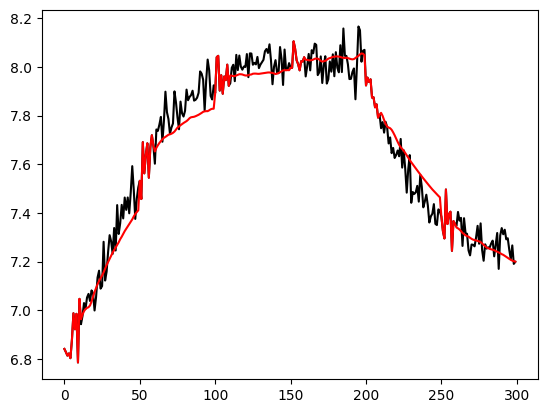

In [79]:
Y_off, Y_pred = data[0], data[1]
print(mse(Y_off, Y_pred))
plt.plot(Y_off, c='k')
plt.plot(Y_pred, c='r')
np.savetxt("results/GRU/offline.csv",np.column_stack((Y_off, Y_pred)), delimiter=",")

In [76]:
import pickle
with open("models/preprocessor.obj", "wb") as f:
    pickle.dump(pre, f)

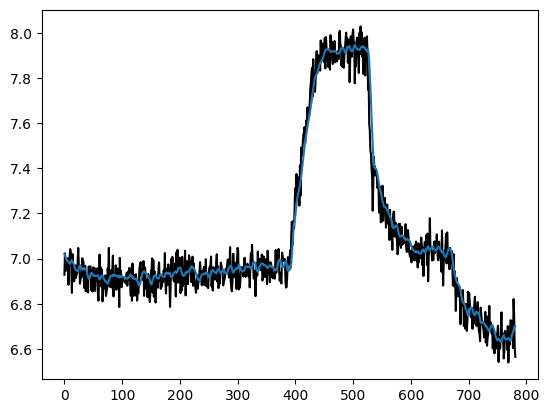

In [78]:
pid_x, pid_y = data_to_X_Y(pid11[:,1:], best_params["window_size"])
pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], best_params["window_size"])
pid_xfull = np.vstack([pid_x, pid_x2])
pid_yfull = np.concatenate([pid_y, pid_y2])

plt.plot(pid_yfull, c='k')
plt.plot(best_model(pre(pid_xfull)))